# Loan Acceptance Classifier

**Table of contents**<a id='toc0_'></a>    
- [Imports and Settings](#toc1_1_)    
- [Pipelines](#toc2_)    
  - [LightGBM](#toc2_1_)    
    - [Imputers](#toc2_1_1_)    
    - [Encoders and selection](#toc2_1_2_)    
    - [Baseline for tunning](#toc2_1_3_)    
  - [Decision Tree](#toc2_2_)    
  - [Logistic regression](#toc2_3_)    
- [Hyperparameter Tuning](#toc3_)    
    - [Replacing Boruta with a Manual Feature Remover](#toc3_1_1_)    
- [Model Selection And Testing](#toc4_)    
  - [Model Selection](#toc4_1_)    
  - [Feature importance](#toc4_2_)    
  - [Final Testing](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=4
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_'></a>[Imports and Settings](#toc0_)

##### Imports

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

##### Settings

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

##### Loading the training and validation data:

In [3]:
data_train=pl.read_parquet('data/data_full_train.parquet')
data_val=pl.read_parquet('data/data_full_val.parquet')

##### Running cleaning and feature engineering functions:

In [4]:
data_train=dmf.clean_accepted_rejected(data_train)
data_val=dmf.clean_accepted_rejected(data_val)

data_train=feats.date_features_accepted_rejected(data_train,"Application Date")
data_val=feats.date_features_accepted_rejected(data_val,"Application Date")

data_train=feats.title_text_features(data_train)
data_val=feats.title_text_features(data_val)

The data was processed into a uniform format, the title was categorized by purpose. Several features were added:
1. The length of the original title
2. Wether the title started with a lowercase
3. Wether the title had any numbers
4. Sine and cosine transformations of the month of the year

##### Setting up X and y data:

In [5]:
X_train = data_train.drop(columns=['Policy Code'])
X_val= data_val.drop(columns=['Policy Code'])
y_train = data_train['Policy Code']
y_val= data_val['Policy Code']

##### Allocating 3M rows of the training set and 900k rows of the validation set for hyperparameter tuning:

In [6]:
X_mini_train, discard1, y_mini_train, discard2 = train_test_split(
    X_train, y_train, stratify=y_train,train_size=3000000
)

X_mini_val, X_val, y_mini_val, y_val = train_test_split(
    X_val, y_val, stratify=y_val,train_size=900000
)

## <a id='toc2_'></a>[Pipelines](#toc0_)

### <a id='toc2_1_'></a>[LightGBM](#toc0_)

#### <a id='toc2_1_1_'></a>[Imputers](#toc0_)

In [7]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value="other")
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value="other")
state_imputer=tr.NotInImputerPolars(cat_no=51,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)


imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("title_imp",title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step("zip_code_imp", zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step("state_imp",state_imputer, "State"),
        tr.PolarsColumnTransformer.Step("len_imp",emp_length_imputer, "Employment Length"),
    ]
)

A custom "NotInImputer" is used for categorical data that filters out all the values that are not in the n number of most popular categories for that column and changes those values to a specified value like "other"

#### <a id='toc2_1_2_'></a>[Encoders and selection](#toc0_)

In [8]:
state_encoder = tr.TargetMeanOrderedLabeler()
zip_encoder = tr.TargetMeanOrderedLabeler()
title_encoder = tr.TargetMeanOrderedLabeler()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder = tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("state", state_encoder, "State"),
        tr.PolarsColumnTransformer.Step("zip_code",zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step("title", title_encoder, "title"),
        tr.PolarsColumnTransformer.Step("emp_length", employment_encoder, "Employment Length"),
    ]
)
null_imp = tr.PolarsNullImputer(fill_value=-9)

model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    force_col_wise=True,
    verbose=-1,
    num_threads=1,
    random_state=1,
)

boruta = tr.BorutaFeatureSelectorPolars(model_lgbm, random_state=1, perc=100)

preprocess_lgbm = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("null_imputer", null_imp),
        ("boruta", boruta),
    ]
)

An ordinal encoder is used for employment length with a manually set order by years.
For other categorical features a target mean encoder is used. This encoder has two options:
1. Changes the values to a mean of the target column for that category in the training set.
2. Orders the categories by that mean, but changes the value to uniform integer labels.

This option is tuned alongside hyperparameters.
A feature selection based on the boruta algorithm was also incorporated into the pipeline, using a reference of the final model in the pipeline. This transformer has two parameters that are tuned: Boruta percentage, which roughly means feature selection strictness and a option to not apply the feature selection at all.

#### <a id='toc2_1_3_'></a>[Baseline for tunning](#toc0_)

In [9]:
model_lgbm.fit(
    preprocess_lgbm.fit_transform(
        X_mini_train.sample(100000, seed=1), y_mini_train.sample(100000, seed=1)
    ),
    y_mini_train.sample(100000, seed=1),
)
baseline_preds=model_lgbm.predict(preprocess_lgbm.transform(X_mini_val.sample(30000,seed=1)))
print(round(f1_score(y_mini_val.sample(30000,seed=1),baseline_preds),2))

0.59


A sample of the data was fitted with the untuned LightGBM model to get a sense of what f1 scores we can expect. This was done to help set a threshold for early stopping in hyperparameter tuning.

##### LightGBM full pipeline and parameter space:

In [10]:
full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1, 100),
    "preprocess__boruta__apply": tune.choice([True, False]),
    "model__num_leaves": tune.randint(10, 150),
    "model__n_estimators": tune.randint(5, 200),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 10),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 200),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models = tunes.Models()
models.add_model("lgbm_yn", full_pipeline, search_space_lgbm, metric_threshold=0.65)

### <a id='toc2_2_'></a>[Decision Tree](#toc0_)

In [11]:
imputer_tree = copy.deepcopy(imputer)
encoder_tree = copy.deepcopy(encoder)
null_imp_tree = copy.deepcopy(null_imp)
preprocess_tree = Pipeline(
    [
        ("imputer", imputer_tree),
        ("encoder", encoder_tree),
        ("null_imputer", null_imp_tree),
    ]
)

model_tree = DecisionTreeClassifier(random_state=1)

full_pipeline_tree = Pipeline(
    [
        ("preprocess", preprocess_tree),
        ("model", model_tree),
    ]
)

search_space_tree = {
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "tree_yn", full_pipeline_tree, search_space_tree, metric_threshold=0.6
)

### <a id='toc2_3_'></a>[Logistic regression](#toc0_)

In [12]:
imputer_logreg = copy.deepcopy(imputer)
encoder_logreg = copy.deepcopy(encoder)
null_imp_logreg = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(
            "dti_imp", tr.PolarsNullImputer(10000), "Debt-To-Income Ratio"
        ),
        tr.PolarsColumnTransformer.Step(
            "requested_imp", tr.PolarsNullImputer(0), "Amount Requested"
        ),
        tr.PolarsColumnTransformer.Step(
            "contains_num_imp", tr.PolarsNullImputer(0), "title_contains_numbers"
        ),
        tr.PolarsColumnTransformer.Step(
            "lowercase_imp", tr.PolarsNullImputer(0), "title_starts_with_lowercase"
        ),
        tr.PolarsColumnTransformer.Step(
            "title_len_imp", tr.PolarsNullImputer(0), "title_length"
        ),
    ]
)

scaler=StandardScaler()

preprocess_logreg = Pipeline(
    [
        ("imputer", imputer_logreg),
        ("encoder", encoder_logreg),
        ("null_imputer", null_imp_logreg),
        ("scaler", scaler)
    ]
)

model_logreg = LogisticRegression(class_weight="balanced", max_iter=1000, tol=0.01, random_state=1)

full_pipeline_logreg = Pipeline(
    [
        ("preprocess", preprocess_logreg),
        ("model", model_logreg),
    ]
)

search_space_logreg = {
    "model__class_weight":tune.choice(['balanced',None]),
    "model__penalty": tune.choice(
        [
            "l1",
            "l2",
            None
        ]
    ),
    "model__C": tune.loguniform(0.001, 10.0),
    "model__solver": tune.choice(["saga"]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "logreg_yn",
    full_pipeline_logreg,
    search_space_logreg,
    metric_threshold=0.47,
    override_n=52,
)

## <a id='toc3_'></a>[Hyperparameter Tuning](#toc0_)

##### Tuning the hyperparameters of all models:

```python
models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=120,sample_size=300000)
joblib.dump(models, 'temp/tuned_models_yn2.joblib')
```

##### Loading the tuned models from a file:

In [13]:
models=joblib.load('temp/tuned_models_yn2.joblib')

The models are organized within a dedicated "model holder" class, which streamlines the setup of essential tools for hyperparameter tuning for each model. The tuning process is facilitated using Ray-Tune with the Optuna algorithm. 

At the outset of each experiment, indexes for ten distinct, stratified samples are derived from the training set, comprising 300,000 instances, and the validation set, containing 100,000 instances. Throughout the experiment, the data is trained on these sample sets, and the F1-score of the positive class is computed for predictions made on the validation set sample using a predefined set of hyperparameters. This process is repeated up to ten times, each with different sample data. 

Notably, after three iterations, experiments that fail to meet a pre-established F1 score threshold are terminated. Employing this methodology, the best trials are assessed on a cumulative dataset consisting of 3 million training data rows and 1 million validation data rows. This approach effectively enables hyperparameter tuning on a substantial dataset while also optimizing RAM usage and saving time by preemptively discontinuing underperforming experiments.

##### The best parameters of the LightGBM model:

In [14]:
models.models['lgbm_yn'].best_params

{'preprocess__boruta__perc': 96,
 'preprocess__boruta__apply': False,
 'model__num_leaves': 102,
 'model__n_estimators': 81,
 'model__learning_rate': 0.0035177130677962617,
 'model__bagging_freq': 0,
 'model__colsample_bytree': 0.5271056292188826,
 'model__subsample': 0.45336580978495056,
 'model__reg_alpha': 2.8552865967655805,
 'model__reg_lambda': 0.00325459871999461,
 'model__boosting_type': 'rf',
 'model__class_weight': None,
 'model__max_bin': 184,
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'label'},
  'title': {'how': 'label'}}}

##### The best parameters of the Decision Tree model:

In [15]:
models.models['tree_yn'].best_params

{'model__criterion': 'entropy',
 'model__splitter': 'best',
 'model__max_depth': 8,
 'model__max_features': None,
 'model__class_weight': None,
 'preprocess__encoder__step_params': {'state': {'how': 'mean'},
  'zip_code': {'how': 'mean'},
  'title': {'how': 'mean'}}}

##### The best parameters of the Logistic regression model:

In [16]:
models.models['logreg_yn'].best_params

{'model__class_weight': None,
 'model__penalty': 'l1',
 'model__C': 0.0010764708820232727,
 'model__solver': 'saga',
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'mean'},
  'title': {'how': 'mean'}}}

#### <a id='toc3_1_1_'></a>[Replacing Boruta with a Manual Feature Remover](#toc0_)

The Bortua algorithm slows the models performance from tens to hundreds of times. Because of this the features to be removed are calculated using it once and then a manual feature remover with pre calculated columns to remove is added instead. 

##### Features dropped by Boruta:

In [17]:
selected_features = (
    models.models["lgbm_yn"]
    .pipeline["preprocess"]
    .fit_transform(
        X_mini_train, y_mini_train
    )
    .columns
)
features_to_drop = [
    feature for feature in X_mini_train.columns if feature not in selected_features
]
features_to_drop

[]

##### Changing the step in the pipeline with a manual feature remover:

In [18]:
models.models["lgbm_yn"].pipeline["preprocess"].steps.pop(-1)
models.models["lgbm_yn"].pipeline["preprocess"].steps.append(
    ("feature_remover", tr.FeatureRemover(feats_to_drop=features_to_drop))
)

##### Dropping features manually instead of Boruta algorithm:

## <a id='toc4_'></a>[Model Selection And Testing](#toc0_)

### <a id='toc4_1_'></a>[Model Selection](#toc0_)

##### Training the models on the full training set:

In [19]:
models.models['lgbm_yn'].pipeline.fit(X_train,y_train)
models.models['logreg_yn'].pipeline.fit(X_train,y_train)
models.models['tree_yn'].pipeline.fit(X_train,y_train)
# joblib.dump(models,'temp/trained_models_yn')


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('title_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa0b975bd60>),
                                                                             ('zip_code_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa0b975b310>),
                                                                             ('state_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step ob...
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7f9ebb6fe850>),
                                                                             ('title',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa0b9759850>),
                                                                             ('emp_length',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa0b9759610>)]))),
                                 ('null_imputer',
                                  PolarsNullImputer(fill_value=-9))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8))])

##### Making predictions on the validation set:

In [20]:
preds_lgbm =models.models['lgbm_yn'].pipeline.predict(X_val)
preds_logreg =models.models['logreg_yn'].pipeline.predict(X_val)
preds_tree =models.models['tree_yn'].pipeline.predict(X_val)


##### Classification reports for each model:

In [21]:
print(classification_report(y_val,preds_lgbm))
print(classification_report(y_val,preds_tree))
print(classification_report(y_val,preds_logreg))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98   6225688
           1       0.63      0.75      0.69    390464

    accuracy                           0.96   6616152
   macro avg       0.81      0.86      0.83   6616152
weighted avg       0.96      0.96      0.96   6616152

              precision    recall  f1-score   support

           0       0.98      0.98      0.98   6225688
           1       0.64      0.71      0.68    390464

    accuracy                           0.96   6616152
   macro avg       0.81      0.84      0.83   6616152
weighted avg       0.96      0.96      0.96   6616152

              precision    recall  f1-score   support

           0       0.96      0.99      0.97   6225688
           1       0.66      0.37      0.48    390464

    accuracy                           0.95   6616152
   macro avg       0.81      0.68      0.73   6616152
weighted avg       0.94      0.95      0.95   6616152



The performance of the decision tree and LightGBM models is remarkably similar, with an identical accuracy rate of 96%. However, the LightGBM model outperforms in terms of recall for the positive class, indicating its superior ability to detect acceptable loan applications. Because of this the LightGBM model is selected as the best one.

In [22]:
best_pipeline=models.models['lgbm_yn'].pipeline

### <a id='toc4_2_'></a>[Feature importance](#toc0_)

##### Calculating and displaying shap values of features:

 95%|=================== | 9541/10000 [00:20<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


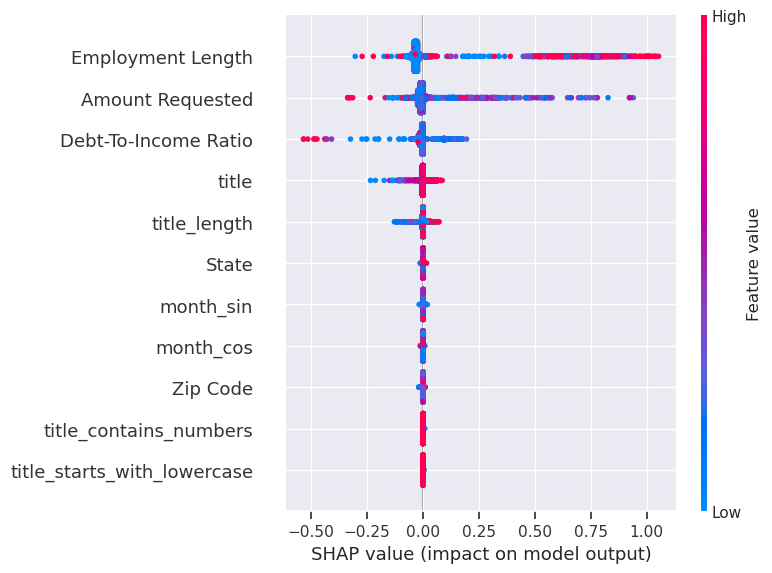

In [23]:
names = best_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    best_pipeline["model"],
    data=best_pipeline["preprocess"]
    .transform((X_mini_val.sample(10000, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

Based on SHAP values, The model primarily bases its decisions on several key features, including the applicant's employment length, Debt-to-Income ratio, the requested loan amount, and the purpose stated in the application title.

### <a id='toc4_3_'></a>[Final Testing](#toc0_)

##### Fitting the model on the Training and the Validation sets:

In [24]:
best_pipeline.fit(X_train.vstack(X_val), pl.concat([y_train,y_val]))

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('title_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa0b9767400>),
                                                                             ('zip_code_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fa0b9767100>),
                                                                             ('state_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step ob...
                 LGBMClassifier(bagging_freq=0, boosting_type='rf',
                                colsample_bytree=0.5271056292188826,
                                force_col_wise=True,
                                learning_rate=0.0035177130677962617,
                                max_bin=184, n_estimators=81, num_leaves=102,
                                num_threads=1,
                                random_state=RandomState(MT19937) at 0x7FA0BA185C40,
                                reg_alpha=2.8552865967655805,
                                reg_lambda=0.00325459871999461,
                                subsample=0.45336580978495056, verbose=-1))])

##### Loading the test data:

In [25]:
data_test=pl.read_parquet('data/data_full_test.parquet')

data_test=dmf.clean_accepted_rejected(data_test)
data_test=feats.date_features_accepted_rejected(data_test,"Application Date")
data_test=feats.title_text_features(data_test)

X_test = data_test.drop(columns=["Policy Code"])
y_test = data_test["Policy Code"]

##### Testing the model on new data:

In [26]:
final_preds = best_pipeline.predict(X_test)
print(classification_report(data_test["Policy Code"], final_preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98   9496782
           1       0.59      0.75      0.66    495242

    accuracy                           0.96   9992024
   macro avg       0.79      0.86      0.82   9992024
weighted avg       0.97      0.96      0.96   9992024



The model's performance remained consistent when tested on entirely new data from a different year, demonstrating its robustness.

##### Exporting the final model trained on all available data:

In [27]:
best_pipeline.fit(X_train.vstack(X_val).vstack(X_test), pl.concat([y_train,y_val,y_test]))
joblib.dump(best_pipeline,"trained_models/final_model_accepted_rejected.joblib")

['trained_models/final_model_accepted_rejected.joblib']